In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.CIFAR as CIFAR
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import numpy as np

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [4]:
config = configClasses.OnlineLearningConfig()
config.EPOCHS = 20
config.EWC_IMPORTANCE = 500
config.L1_REG = 0
config.SAVE_PATH = './models/cifar10/ewc-vs-noewc'
config.MODEL_NAME = 'ewc'
print(config)

confing_no_ewt = copy.copy(config)
confing_no_ewt.USE_EWC = False
config.MODEL_NAME = 'no_ewc'
print(confing_no_ewt)

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 500
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: True
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: ewc
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/cifar10/ewc-vs-noewc
USE_EWC: True
USE_TENSORBOARD: True

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 500
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: True
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: ewc
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/cifar10/ewc-vs-noewc
USE_EWC: False
USE_TENSORBOARD: True



In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
)

dataset = CIFAR.Cifar10('../data/cifar10', SingleTargetClassificationTask(), download=True,
                        force_download=False, train_split=0.8, transform=transform, target_transform=None)
dataset.load_dataset()


../data/cifar10/download
task #0 with train 48000 and test 12000 images (label: airplane)
task #1 with train 48000 and test 12000 images (label: automobile)
task #2 with train 48000 and test 12000 images (label: bird)
task #3 with train 48000 and test 12000 images (label: cat)
task #4 with train 48000 and test 12000 images (label: deer)
task #5 with train 48000 and test 12000 images (label: dog)
task #6 with train 48000 and test 12000 images (label: frog)
task #7 with train 48000 and test 12000 images (label: horse)
task #8 with train 48000 and test 12000 images (label: ship)
task #9 with train 48000 and test 12000 images (label: truck)


In [6]:
net_ewt = NoKafnet.CNN(dataset.tasks_number)
net_no_ewt = copy.deepcopy(net_ewt)

print('Numero di parametri rete classica: ', sum([torch.numel(p) for p in net_ewt.parameters()]))

Numero di parametri rete classica:  171732


In [7]:
trainer_ewt = Trainer(net_ewt, copy.deepcopy(dataset), config)
trainer_no_ewt = Trainer(net_no_ewt, copy.deepcopy(dataset), confing_no_ewt)

In [8]:
metrics_ewt = trainer_ewt.load()
if not metrics_ewt:
    metrics_ewt = trainer_ewt.all_tasks()

In [9]:
metrics_no_ewt = trainer_no_ewt.load()
if not metrics_no_ewt:
    metrics_no_ewt = trainer_no_ewt.all_tasks()

In [10]:
print('Ewt', metrics_ewt['metrics'])
print('No ewt', metrics_no_ewt['metrics'])

Ewt {'fwt': 0.8960500000000001, 'bwt': -0.012112962962962947, 'remembering': 0.9878870370370371, 'pbwt': 0, 'accuracy': 0.648831818181818}
No ewt {'fwt': 0.8580944444444446, 'bwt': -0.050848148148148135, 'remembering': 0.9491518518518519, 'pbwt': 0, 'accuracy': 0.6026166666666667}


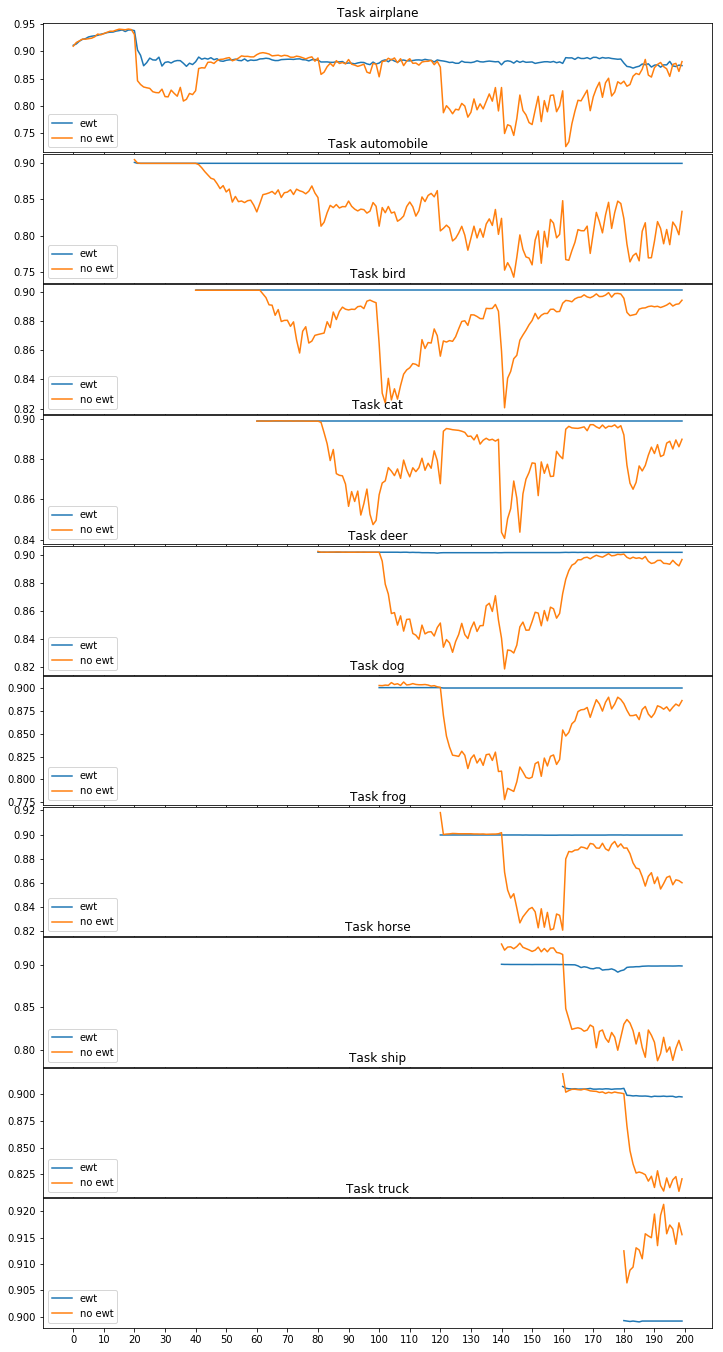

In [14]:
n_task = len(metrics_no_ewt['tasks'])
tot_epochs = 0

for k, v in metrics_no_ewt['tasks'].items():
    tot_epochs = max(tot_epochs, len(v['accuracy']))
             
for k, v in metrics_ewt['tasks'].items():
    tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig = plt.figure(figsize=(12, 24))

ax = None
for i, task in enumerate(metrics_no_ewt['tasks'].keys()):
        
    ewt = metrics_ewt['tasks'][task]
    no_ewt = metrics_no_ewt['tasks'][task]

    x = range(tot_epochs-len(no_ewt['accuracy']), tot_epochs)

    ax = fig.add_subplot(n_task, 1, i+1, sharex=ax) 
    
    ax.plot(x, ewt['accuracy'], label='ewt')
    ax.plot(x, no_ewt['accuracy'], label='no ewt')

    ax.set_xticks(range(0, tot_epochs+1, 10),minor=False)
    
    ax.set_title("Task {}".format(dataset.idx_to_class[int(task)]))
    ax.legend(loc="lower left")
    
fig.subplots_adjust(hspace=0.01)
